# Homework 5

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

%matplotlib inline

The dataset used is 70,000 handwritten digits. This dataset is common for learning image recognition, especially with neural nets. However, I'll be using it to demonstrate dimensionality reduction techniques, which is usually a preprocessing step to many machine learning techniques.

In [1]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
y = mnist.target

In [3]:
print('Number of rows:', X.shape[0])
print('Number of features:', X.shape[1])

Number of rows: 70000
Number of features: 784


Each image is one row and is 28x28 pixels. This is a cumbersome number of features and can easily cause a model to overfit or take much longer to run. However, reducing dimensionality can reduce too much variance and increase bias. Fortunately, many of these features are likely to be correlated with the others because pixels near each other are likely the same hue. Algorithms like PCA can help reduce the dimensionality while keeping the variance in the data.

# PCA

PCA uses singular value decomposition to derive the eigenvectors with the highest variance. This creates components that preserves the the variance and thus the maximum amount of information while reducing dimensionality. It has one hyper-parameter, the number of components.

## How to Choose Components

The number of components affects the amount of information preserved from the original dataset and controls the amount of explained variance. Explained variance is the ratio of the original variance in the dataset explained by the reduced dataset. There are two typical techniques for choosing the number of components. First, you can choose the amount of explained variance directly. A general guideline is to preserve 95% of the variance. Second, you can choose the the number of components directly. Let's look at a graph of the number of components and the explained variance to get a clear picture of how you want to choose the number of components.

Text(0,0.5,'Explained Variance')

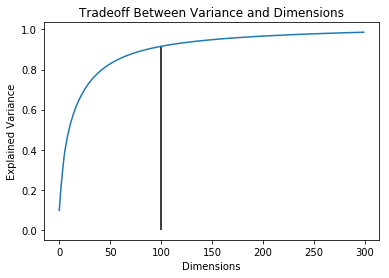

In [4]:
pca = PCA(n_components=300)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0, ymax=cum_ratio[100], x=100)
plt.title('Tradeoff Between Variance and Dimensions')
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')

There is an elbow in the graph of explained variance that is intuitively the intrinsic dimensionality of the dataset. If you choose the number of dimensions after the elbow, you maximize the number of dimensions dropped while minimizing the amount of variance lost. From this graph, 100 components seems like a reasonable choice. Before making this choice, let's look at how many components preserve 95% of the variance.

In [5]:
pca = PCA(n_components=0.95)

In [6]:
X_pca = pca.fit_transform(X)

In [7]:
print('Number of components that explains 95% of the variance:', X_pca.shape[1])

Number of components that explains 95% of the variance: 154


Compared to my personal choice, there are 154 components using this method. Anywhere from 100 to 154 is likely viable. However, since this dataset has a decent number of observations, I feel that picking 154 components is reasonable. Let's carry on with those components.

## Visualizing the First Components

Let's look at the first two components of the PCA.

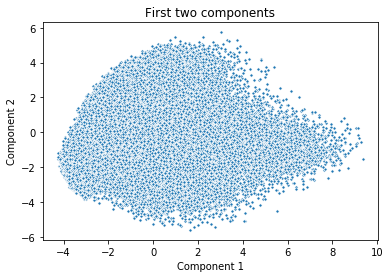

In [8]:
plt.title('First two components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], **{'s': 10})

The first component does have more variance than the second component, as expected. Let's look at the data with labels to see whether digits are clustered together.

Text(27.5077,0.5,'Component 2')

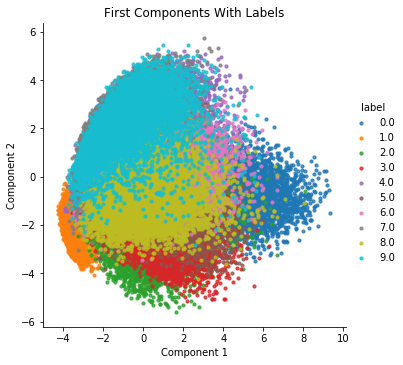

In [9]:
sns.lmplot(x='1', y='2', 
           data=pd.DataFrame({'1': X_pca[:,0], '2': X_pca[:,1], 'label': y}),
           hue='label', fit_reg=False, scatter_kws={'s': 10})

plt.title('First Components With Labels')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Each group is clustered, but groups often overlap with each other. However, PCA is not really intended for visualization since keeping the components with the most variance isn't the most intuitive way of thinking about clusters. T-SNE later on will give a better visualization of the clusters.

## Compression and Rescaling

One of the benefits of PCA is that you can reverse the compression. You don't restore the lost variance, but you can visualize the orignal image or data again. Let's take a look at this in action.

In [10]:
def plot_image(row_of_pixels, axis_object):
    axis_object.imshow(row_of_pixels.reshape(28,28), cmap='Greys')

Text(0.5,0.98,'Original Digits')

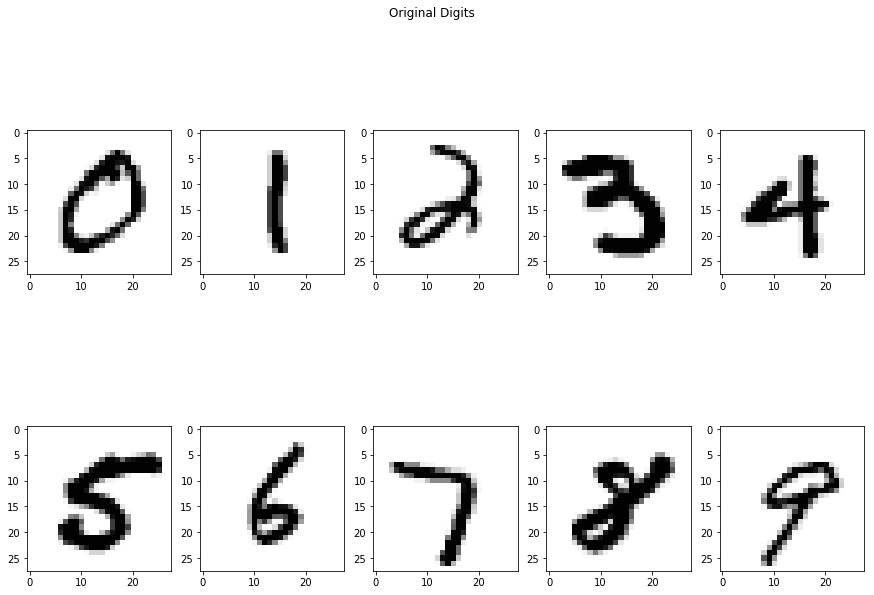

In [11]:
def graph_digits(data):
    fig, ax = plt.subplots(nrows=2, ncols=5)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    i = 0
    for j in range(2):
        for k in range(5):
            ax[j,k].imshow(data[i,:].reshape(28,28), cmap='Greys')
            i += 6500
graph_digits(X)
plt.suptitle('Original Digits')

In [12]:
reconstructed_image = pca.inverse_transform(X_pca)

Text(0.5,0.98,'Reconstructed Digits From Compression')

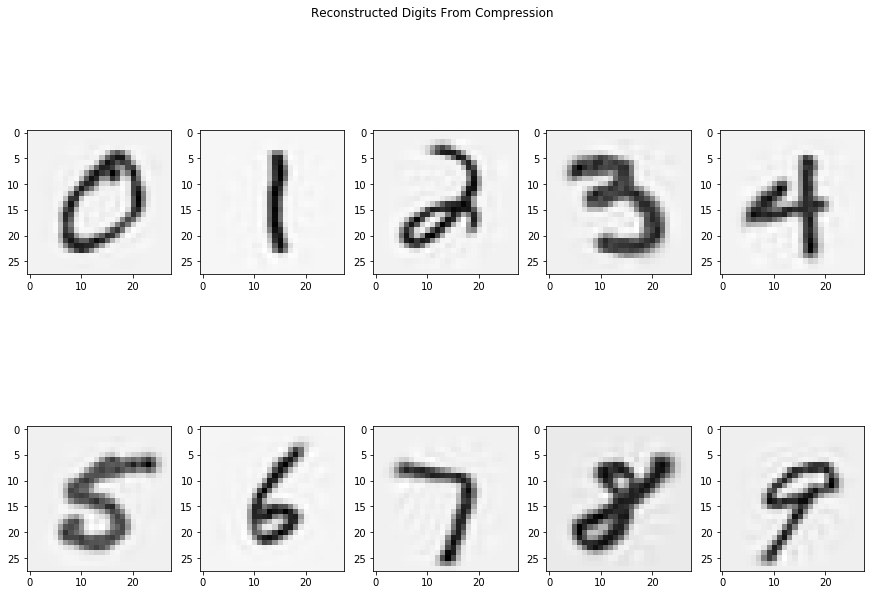

In [13]:
graph_digits(reconstructed_image)
plt.suptitle('Reconstructed Digits From Compression')

PCA did a good job of preserving the original image with this number of dimensions. Let's see what it looks like with a lower amount of dimensions.

Text(0.5,0.98,'Large Compression Digits')

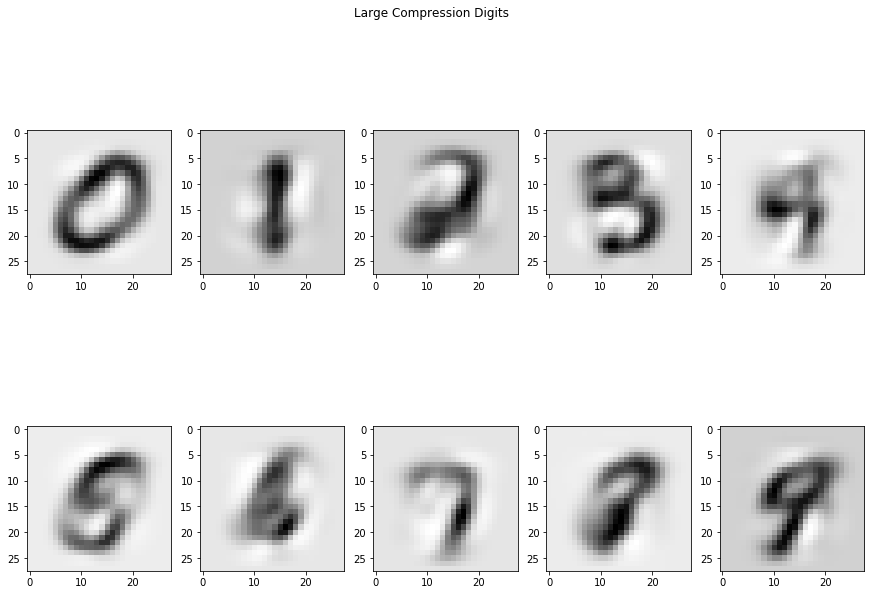

In [14]:
small_pca = PCA(n_components=10)
small_X = small_pca.fit_transform(X)
small_X = small_pca.inverse_transform(small_X)
graph_digits(small_X)
plt.suptitle('Large Compression Digits')

You can still see the general outline of the numbers, but it definitely loses a lot of the form. 2, 3, and 8 especially look similar to each other, along with 4 and 9.

## Reasons for PCA

Pros:
- Reduces Dimensionality
- Simple algorithm and easily understood
- Preserves as much variance as possible while reducing dimensions
- Great for data preprocessing

Cons:
- Not great for visualization
- Highlights high variance over other structural aspects of the data
- Makes assumptions regarding linearity

# t-SNE

Since PCA is not really built for visualization, let's look at a model that is great for that purpose. t-SNE tries to preserve the closeness of local points in lower dimensions. Unlike PCA, it does this in a nonlinear way. t-SNE's main hyper-parameter is perplexity, which is essentially a balance between the local fit and global fit of the model. It's recommended to use a number between 5 and 50 for perplexity, and it is an appoximate guess as to the number of neighbors of a point. Let's generate a model with a perplexity of 50 to start using the image data. 

In [7]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 1000

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X[rows[:n_select],:])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.014s...
[t-SNE] Computed neighbors for 1000 samples in 1.579s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.898465
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.568764
[t-SNE] Error after 1000 iterations: 1.039170


Text(0.5,1,'t-SNE graph of digits')

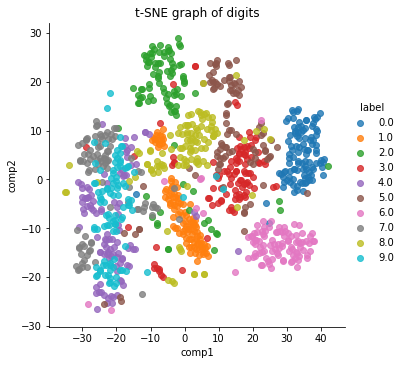

In [16]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE graph of digits')

It did a fairly decent job a grouping each of the digits. There's some bleed between digits, like some 3's fall into the 8 cluster. Also, 9's and 4's are clustered together. Coincidentally, these pairs of digits also appeared similar when the PCA compressed to 10 dimensions. With t-SNE, the relative distance between and within clusters is not that meaningful; the separation between clusters is the most important part of t-SNE. Now, let's take a look at t-SNE's robustness to perplexity.

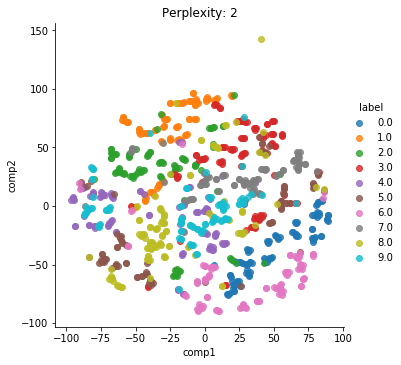

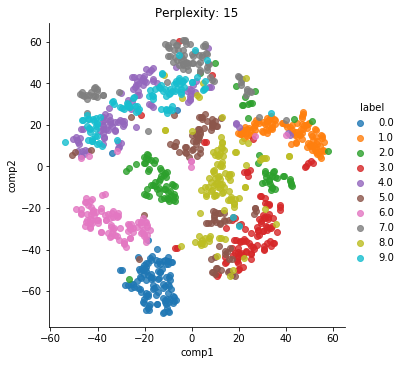

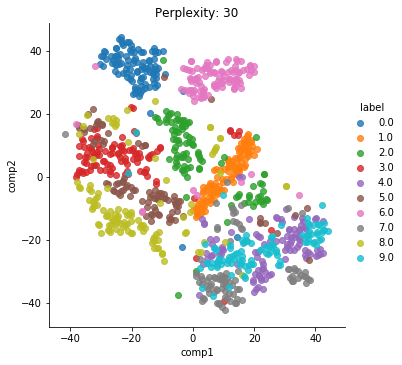

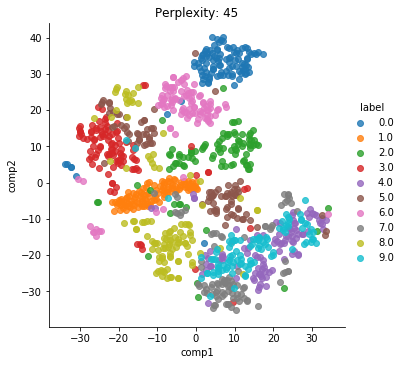

In [17]:
def create_tsne_graph(perp=50, it=1000, learn=200):
    tsne = TSNE(n_components=2, verbose=0, perplexity=perp, n_iter=it, learning_rate=learn)
    tsne_results = tsne.fit_transform(X[rows[:n_select],:])
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = y[rows[:n_select]]
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
for i in [2, 15, 30, 45]:
    create_tsne_graph(perp=i)
    plt.title('Perplexity: {}'.format(i))

Low perplexities give really small clumps because it's too local and only considering a few of the nearest neighbors. Higher perplexity works better for this sample.

There are also two other minor hyper-parameters: number of iterations and learning rate. These control how fast t-SNE learns relationships and for how long t-SNE learns. A low learning rate creates unintended clumping in the data, while a high learning rate leads to points being equidistant from each other to form a ball. A low number of iterations means that it might not converge when it stops.

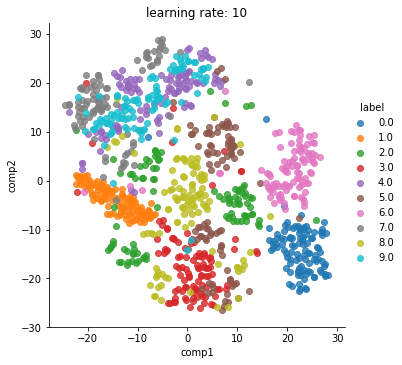

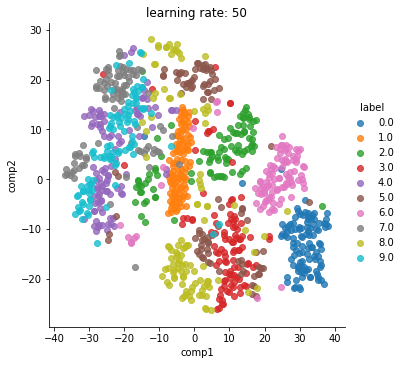

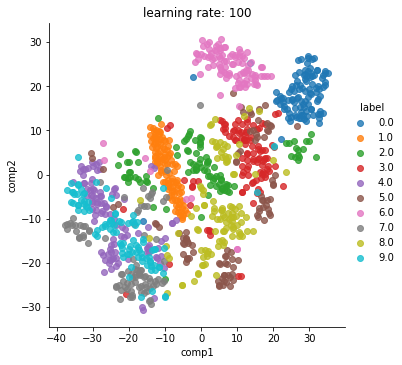

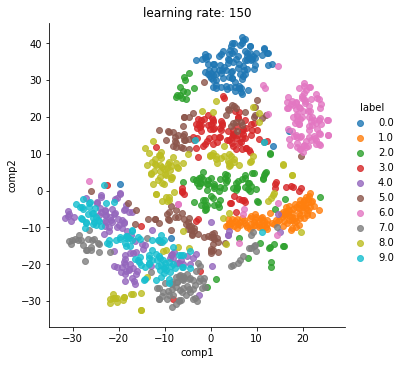

In [18]:
for i in [10, 50, 100, 150]:
    create_tsne_graph(learn=i)
    plt.title('learning rate: {}'.format(i))

For this sample, the learning rate didn't affect much. It did create more concentrated clusters than the low learning rates.

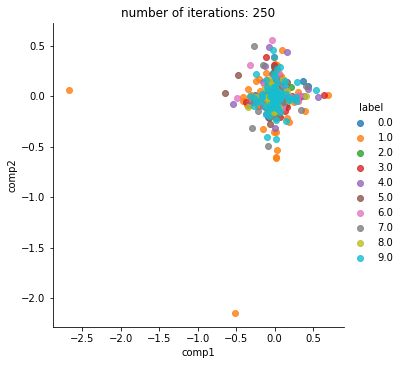

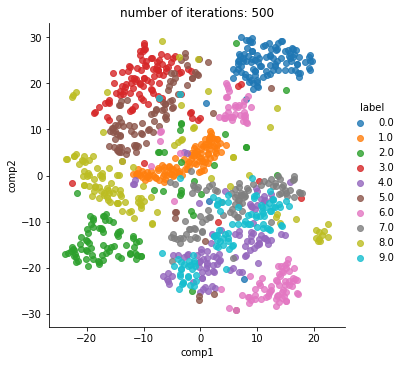

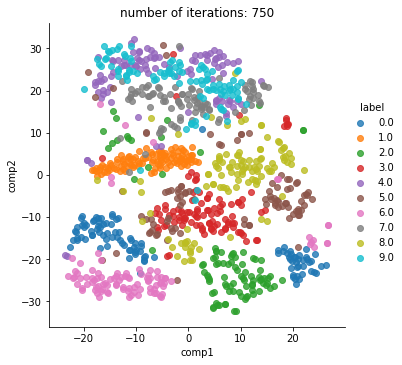

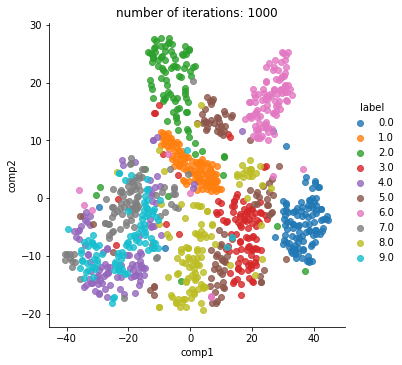

In [19]:
for i in [250, 500, 750, 1000]:
    create_tsne_graph(it=i)
    plt.title('number of iterations: {}'.format(i))

Obviously increasing the number of iterations improves the results. It begins to actually recognize the groups.

# K-means Clustering

While PCA is great for dimensionality reduction and t-SNE is great for visualization, both models do not create labels for clusters. K-means does so in an unsupervised way, where it doesn't have labels on the data to create the clusters. Thus, K-means is suited for tasks where it's very difficult or costly to create labels.

The algorithm works as follows. First, you set a number of label for the program to find. Then, you assign a random label to each observation. Within the clusters of each label, compute the centroid of the cluster, and reassign observations to the closest centroid. Once it reaches a local minimum, the algorithm stops.

Choosing the number of clusters, k, can be somewhat of an art. You choose clusters based on prior knowledge of the data or by which k fits the data the best. In the case of the digit data, there are 10 clusters already known, so I set the clusters to 10.

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans.fit(X)
digit_clusters = kmeans.predict(X)

## Evaluation

The observations are grouped by digit, so I can actually see its accuracy by looking at ranges of the data.

In [21]:
test = pd.Series(digit_clusters)
print('Zero clusters')
test[:5923].value_counts()

Zero clusters


5    4321
0    1111
6     238
7     137
2      64
3      36
8       7
4       5
9       2
1       2
dtype: int64

In [22]:
print('One clusters')
test[5923:12665].value_counts()

One clusters


9    3648
1    3043
4      11
8       9
3       7
2       7
6       6
0       6
7       5
dtype: int64

In [23]:
print('Two clusters')
test[12665:18623].value_counts()

Two clusters


8    4157
9     365
1     350
6     275
0     220
3     185
2     167
7     126
4      67
5      46
dtype: int64

In [24]:
print('Three clusters')
test[18623:24754].value_counts()

Three clusters


6    3888
2     943
0     408
9     387
8     185
3     176
1      56
4      37
7      28
5      23
dtype: int64

In [25]:
print('Four clusters')
test[24754:30596].value_counts()

Four clusters


3    3169
4    1878
0     239
1     210
9     149
7     146
8      28
2      15
5       8
dtype: int64

In [26]:
print('Five clusters')
test[30596:36017].value_counts()

Five clusters


6    1819
0    1575
2     986
3     372
1     248
4     170
9     136
7      56
5      54
8       5
dtype: int64

In [27]:
print('Six clusters')
test[36017:41935].value_counts()

Six clusters


7    3668
0    1834
9     171
3      55
5      53
8      43
1      42
6      36
2      13
4       3
dtype: int64

In [28]:
print('Seven clusters')
test[41935:48200].value_counts()

Seven clusters


4    3791
3    1803
9     314
1     263
8      40
5      20
2      15
0      10
6       5
7       4
dtype: int64

In [29]:
print('Eight clusters')
test[48200:54051].value_counts()

Eight clusters


2    3513
6    1027
9     304
1     297
0     254
3     179
4     164
8      44
7      40
5      29
dtype: int64

In [30]:
print('Nine clusters')
test[54051:60000].value_counts()

Nine clusters


3    2915
4    2464
9     233
1      89
6      80
2      70
5      45
0      26
8      16
7      11
dtype: int64

Some clusters are very well defined like 3 and 2. Other clusters are not that great, like 9 and 5. Since K-means doesn't know the original labels of the data, F1 doesn't work for evaluating the effectiveness of K-means. However, sklearn has a function called adjusted_rand_score that matches the labels together. there's also the Silhouette score which examines cluster distance. We'll use both of those.

In [8]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

print('adjusted rand score:', adjusted_rand_score(digit_clusters, y))
print('silhouette score:', silhouette_score(X[rows[:10000]], digit_clusters[rows[:10000]]))

adjusted rand score: 0.3652393015109813
silhouette score: 0.05948008083486121


The adjusted rand score is bounded between 0 and 1 with 1 being the best. the model did ok, but not incredible. The silhouette score is on a subset (because of memory issues). It's bounded between -1 and 1, so it is also just ok.

## Using t-SNE to graph clusters

Let's visualize the clusters using t-SNE.

Text(0.5,1,'t-SNE of K-means labels')

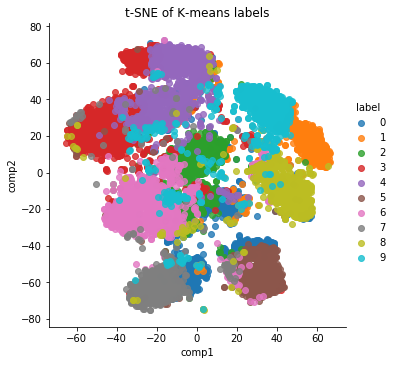

In [32]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X[rows[:1000],:])
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = digit_clusters[rows[:1000]]
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE of K-means labels')

The clusters are fairly good for the K-means assigned labels. Clusters 8 and 1 are not well separated, along with 0, 9, and 3. Comparing this to the true label t-SNE above gives an indication of how well defined each digit cluster is.

## Scaling Data

Scaling data depends on the dataset when using K-means clustering. If features are unrelated, it's important to scale the data. However, if data points have defined distances, like lat and lon data, you shouldn't scale the data to avoid distorting the true distance. Since pixels essentially have a defined "distance", which is the darkness of the pixel, scaling the data isn't wise.

## Robustness

To test robustness let's run a test on a subset of the data and examine the t-SNE again. K-means clustering is fairly sensitive to small changes to the input data, so this will help test whether or not the clustering is stable.

In [9]:
kmeans = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans.fit(X[rows[:10000],:])
small_sample = kmeans.predict(X[rows[:10000],:])

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X[rows[:10000]])
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = small_sample
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

Now, let's change the number of clusters and compare that to the original.

In [ ]:
for i in [5, 7, 20]:
    kmeans = KMeans(n_clusters=i, n_init=50, n_jobs=-1)
    kmeans.fit(X)
    kmeans_pred = kmeans.predict(X)
    tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, learning_rate=200)
    tsne_results = tsne.fit_transform(X[rows[:1000],:])
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = kmeans_pred[rows[:1000]]
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

10 clusters should still be the best since that's the truth. However, it is interesting to note the other clusters.

# Hierarchical Clustering

Another method for clustering is hierarchical clustering. This algorithm starts with each point as its own cluster and slowly agglomerates clusters into larger clusters. This assumes that the data naturally has a hierarchy, which may not be correct for every dataset. To see this in action, let's plot the dendrogram of the hierarchical cluster of the digit data. I'll use 10,000 random rows because of how long the model takes.

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

def create_dendrogram(linkage_method='complete', p_level=7):
    Z = linkage(X[rows[:10000],:], linkage_method)
    plt.figure(figsize=(12, 12))
    _ = dendrogram(Z, p=p_level, truncate_mode='level')
    plt.title('Hierarchical clusters of digits')
create_dendrogram()

We know that there are 10 clusters. Based on the graph, clear clusters start forming at 13.5-14.5. That's anywhere from 7-24 clusters. Based on our knowledge of the data, obviously we should pick a cutoff at 10 clusters. 7 clusters also makes sense since we do see in earlier t-SNE plots that a couple digits are very similar.

## Linkage Methods

To demonstrate hierarchical clustering, I used the complete linkage method. There are actually a few other linkage methods that can be used for clustering. Other popular methods are ward and average. Tyler's notebook has descriptions of each. Let's test a couple other linkage methods.

In [ ]:
create_dendrogram('ward')

Ward starts reaching stable clusters much earlier than complete. It's a lot easier to see each step in the process.

In [ ]:
create_dendrogram('average')

This looks much more sparse than the other dendrograms. Let's increase the p-level to get a better look at the data.

In [ ]:
create_dendrogram('average', 20)

This graph is a lot less clear, but it shows that average never really finds great clusters based on distance except for the very end. The other linkage methods are likely better for this dataset. 